# Relational Databases

DBs play an important role in today's software solutions. All the data applications need or collect from users needs to go somewhere. DBs provide a scalable and reliable mechanism for storing and accessing the data in a consistent way. 

In this lab we will work with relational DBs.

## Requirements
- Python 3.x
- PostgreSQL (<https://www.postgresql.org/>)
- psycopg2 (Postgres library for Python) (<https://pypi.org/project/psycopg2/>)
- Pandas
- Docker Engine (<https://docs.docker.com/engine/install/>)
- Docker Compose (<https://docs.docker.com/compose/install/>)


We will work with containers. If you are not familiar with the concept do not worry, they are very similar to virtual machines. For this course we chose Docker Engine as our container platform.



After installation, we recommend following up on the post-installation steps if you are running on Linux (<https://docs.docker.com/engine/install/linux-postinstall/>), *Manage Docker* as a non-root user and *Configure Docker* to start the docker service on boot (with systemctl).

You can now run the hello-world container to confirm everything works.
```
sudo docker run hello-world
```

## Relational databases

### Setting up the postgres container
Get a Postgres container image from the Docker registry (<https://hub.docker.com/_/postgres>)
```
docker pull postgres
```

Create the container and start it with: 
```
docker run --name bda-postgres -e POSTGRES_PASSWORD=pass1234 -d -p 5432:5432 postgres 
```

Verify the container is running with:
```
docker ps
```

And you should see something like:
```
CONTAINER ID        IMAGE               COMMAND                  CREATED             STATUS              PORTS                    NAMES
c52d12b8b2f6        postgres            "docker-entrypoint.s…"   2 minutes ago        Up 2 minutes        0.0.0.0:5432->5432/tcp   bda-postgres
```
Notice the ports column, Docker is mapping the port 5432 on localhost to the container's port. This means that to reach the DB we just need to connect to localhost:5432.

From now on, you can start and stop the container simply with:
```
docker start bda-postgres
```

```
docker stop bda-postgres
```

### Troubleshooting
pgAdmin is a UI tool that will allow you to visualize the state of the DB at any time. Feel free to use it to monitor your progress as you create the tables and load the data.

### Setting up the connection
We will use the *psycopg2* database adapter.

In [4]:
# uncomment to install
# import sys
# !{sys.executable} -m pip install psycopg2

import psycopg2


try:
    conn = psycopg2.connect("dbname='postgres' user='postgres' host='localhost' password='pass1234'")
    print('Success connecting to the DB')
except:
    print('I am unable to connect to the database')

Success connecting to the DB


## The office dataset

When we are designing how to store our data in a relational database, we usually start with a UML diagram modeling classes and their relationships.

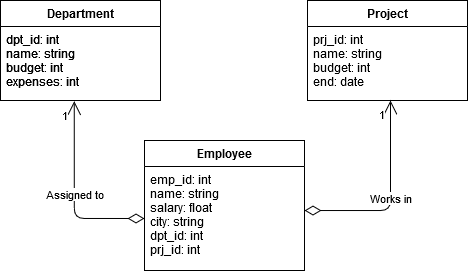

Then, we apply a set of rules to transform these entities into database tables, thus mapping the classes and their directed relationships.

*departments*:

| dpt_id | name | budget | expenses |
| ------ | ---- | ------ | -------- |
| 1 | sales | 50000| 100000|
| 2 | shipping | 10000 | 5000|

*projects*:

| prj_id | name | budget | end |
| ------ | ---- | ------ | --- |
| 1      | al-34 | 1000000 | 11/12/2030|
| 2      | zk-24 | 5000000 | 05/12/2019|

*employees*:

| emp_id | name | salary |city | dpt_id | prj_id
| ------ | ---- | ------ | --- | --- | --- |
| 1 | Jane Doe | 60000 | ROME | 1 | 1 |
| 2 | John Smith | 40000 | BERLIN | 2 | 2 |

Notice that in the employees table we added the id of the department and the project, so that for we can see that information for every employee. This is what is commonly known as foreign keys.

A primary key is the employee id, which cannot be null and cannot be repeated; it is the object identifier.

The code below creates the tables in the DB:

In [5]:
cursor = conn.cursor()
try:
    cursor.execute("""CREATE TABLE PROJECTS (
                        prj_id INTEGER, 
                        "name" VARCHAR(45) NOT NULL, 
                        budget INTEGER, 
                        "end" DATE, 
                        PRIMARY KEY(prj_id))""")
    
    cursor.execute("""CREATE TABLE DEPARTMENTS (
                        dpt_id INTEGER, 
                        "name" VARCHAR(45) NOT NULL, 
                        budget INTEGER, 
                        expenses INTEGER, 
                        PRIMARY KEY(dpt_id))""")

    cursor.execute("""CREATE TABLE EMPLOYEES (
                        emp_id INTEGER, 
                        "name" VARCHAR(45) NOT NULL, 
                        salary FLOAT, 
                        city VARCHAR(45), 
                        dpt_id INTEGER, 
                        prj_id INTEGER,
                        PRIMARY KEY(emp_id),
                        CONSTRAINT fk_project 
                            FOREIGN KEY(prj_id) REFERENCES PROJECTS(prj_id),
                        CONSTRAINT fk_department
                            FOREIGN KEY(dpt_id) REFERENCES DEPARTMENTS(dpt_id))""")     
    conn.commit()
except Exception as e:
    # if the transaction aborts we will need to rollback
    cursor.execute("ROLLBACK")
    print(e)

Something to remember while you experiment with a DB is that if the transaction you are trying to execute fails, you will have to execute a ROLLBACK as we do above. For optimization reasons, the DB performs the updates in memory so if we want to commit our changes to disk, we will need to execute a commit on the connection object.

Now we will load the following datasets in CSV format [departments](./files/company/departments.txt), [projects](./files/company/projects.txt) and [employees](./files/company/employees.txt) into the DB. When loading datasets, it is better to load in bulk than to insert row by row (sample by sample).

In [6]:
with open('./files/company/departments.txt', 'r') as f:
    cursor.copy_from(f, 'departments', sep=',')
with open('./files/company/projects.txt', 'r') as f:
     cursor.copy_from(f, 'projects', sep=',')
with open('./files/company/employees.txt', 'r', encoding='utf-8') as f:
    cursor.copy_from(f, 'employees', sep=',')
conn.commit()

At this point we have successfully set-up the DB and loaded the dataset. We can start the analysis.

## Selecting data
SQL is the language we use to interact with a DB. We have already seen some examples when we created the tables, but now we are going to focus on retrieving information. 

* Select all employees:

In [7]:
cursor.execute("""SELECT * FROM EMPLOYEES""")
rows = cursor.fetchall()
print(rows[0:4])

[(0, 'Wiley Henry', 69682.0, 'San Antonella', 0, 0), (1, 'Marlin Suiter', 87824.0, 'West Tommyton', 0, 0), (2, 'Jennifer Peters', 96745.0, 'Guipúzcoa', 0, 0), (3, 'Donna Paige', 31996.0, 'Lleida', 0, 0)]


* Select a subset of columns:

In [8]:
cursor.execute("""SELECT "name", city FROM EMPLOYEES""")
rows = cursor.fetchall()
print(rows[0:4])

[('Wiley Henry', 'San Antonella'), ('Marlin Suiter', 'West Tommyton'), ('Jennifer Peters', 'Guipúzcoa'), ('Donna Paige', 'Lleida')]


* Filter by condition:

In [52]:
cursor.execute("""SELECT "name", city FROM EMPLOYEES WHERE salary > 70000""")
rows = cursor.fetchall()
print(rows[0:4])

[('Marlin Suiter', 'West Tommyton'), ('Jennifer Peters', 'Guipúzcoa'), ('Carma Parman', 'Scalera ligure'), ('Derek Pace', 'Hernandezburgh')]


* Combination of filters (get the employees with dpt_id different than 0, with a city starting with M or equal to Palencia, Cookton or Rachelburg, with name not null and salary between 50k and 60k):

In [3]:
cursor.execute("""SELECT "name", city FROM EMPLOYEES 
                    WHERE NOT (dpt_id = 0) AND 
                    (
                        city in ('Palencia', 'Cookton', 'Rachelburgh') OR
                        city LIKE 'M%'
                    ) AND 
                    "name" IS NOT NULL AND
                    salary BETWEEN 50000 AND 60000""")
rows = cursor.fetchall()
print(rows[0:4])

[('Kim Shelton', 'Málaga'), ('Gary Sherrill', 'Melilla'), ('James Gibbs', 'Michaelport'), ('Shaniqua Sherrell', 'Milanesi sardo')]


* Get all the different cities:

In [4]:
cursor.execute("""SELECT DISTINCT city FROM EMPLOYEES""")
rows = cursor.fetchall()
print(rows[0:4])

[('Kyleshire',), ('Comencini salentino',), ('Schneidershire',), ('Brandonhaven',)]


### Aggregation functions
SUM, COUNT, MIN, MAX, AVG are functions that can be applied to a query to summarise results.

* Count the number of different cities employees live in and what is the employees average salary:

In [12]:
cursor.execute("""SELECT COUNT(DISTINCT city), AVG(salary) FROM EMPLOYEES""")
rows = cursor.fetchall()
print(rows)

[(2888, 49640.14355555556)]


### Ordering
* Select the employees with a department in 0-4 and order by descending salary and then by name

In [14]:
cursor.execute("""SELECT * FROM EMPLOYEES 
                  WHERE dpt_id IN(0,4)
                  ORDER BY salary DESC, "name" """)
rows = cursor.fetchall()
print(rows[0:4])

[(2128, 'John Hayes', 99940.0, 'Vegaport', 4, 25), (2458, 'James Familia', 99936.0, 'Cádiz', 4, 91), (2424, 'Dian Moore', 99762.0, 'Albacete', 4, 84), (109, 'Craig Hairston', 99420.0, 'Prodi salentino', 0, 21)]


### Grouping
GROUP BY can be used to group rows (samples) by column. For example:

* Which city has the highest average salary?

In [28]:
cursor.execute("""SELECT city, AVG(salary) AS avgSalary FROM EMPLOYEES
                GROUP BY city
                ORDER BY avgSalary DESC""")
rows = cursor.fetchall()
print(rows[0:20])

[('Vegaport', 99940.0), ("Colletti nell'emilia", 99928.0), ('Sesto Cassandra', 99908.0), ('Howellberg', 99859.0), ('Quarto Silvia', 99839.0), ('South Amychester', 99783.0), ('West Vicki', 99745.0), ('Milo umbro', 99690.0), ("Lucarelli nell'emilia", 99686.0), ('Priceberg', 99564.0), ('West Ashleybury', 99559.0), ('East Taylor', 99534.0), ('Asmundo calabro', 99422.0), ('Prodi salentino', 99420.0), ('Chechi salentino', 99400.0), ('Natta salentino', 99282.0), ('Sheltonview', 99255.0), ('Michelleside', 99117.0), ('Quarto Tatiana', 99112.0), ('San Sebastiano', 99106.0)]


We can group results and filter groups with a condition. For example:
* Which city with more than 5 employees has the highest average salary?

In [30]:
cursor.execute("""SELECT city, AVG(salary) AS avgSalary FROM EMPLOYEES
                GROUP BY city
                HAVING COUNT(city) > 5
                ORDER BY avgSalary DESC""")
rows = cursor.fetchall()
print(rows[0:20])

[('León', 60559.04347826087), ('Ciudad', 59690.380952380954), ('Cádiz', 59426.27777777778), ('Zamora', 58900.11111111111), ('Valladolid', 58872.32352941176), ('Lleida', 58844.375), ('Granada', 58084.03571428572), ('Ávila', 56527.142857142855), ('Lugo', 56337.944444444445), ('Asturias', 56045.05882352941), ('Jaén', 55850.114285714284), ('Tarragona', 55412.1875), ('Santa Cruz de Tenerife', 55367.24), ('Baleares', 54404.608695652176), ('Girona', 54366.81481481482), ('Guipúzcoa', 54109.0), ('Madrid', 53987.142857142855), ('Sevilla', 53173.857142857145), ('Barcelona', 52979.666666666664), ('Valencia', 52875.94594594595)]


### Multiple tables
There will be times where we will need to query data distributed over multiple tables. At this point, we will start executing our queries from Pandas, since the returned results are displayed in a dataframe and is easier to keep track of which fields belong to each table.

Let's begin by joining the three tables together using dpt_id and prj_id as keys.

In [9]:
import pandas as pd
import pandas.io.sql as sqlio

sql = "SELECT * FROM EMPLOYEES e, DEPARTMENTS d, PROJECTS p \
       WHERE e.dpt_id=d.dpt_id AND e.prj_id=p.prj_id"
dat = sqlio.read_sql_query(sql, conn)

dat.head()

/tmp/ipykernel_18140/480556971.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dat = sqlio.read_sql_query(sql, conn)


,emp_id,name,salary,city,dpt_id,prj_id,dpt_id,name,budget,expenses,prj_id,name,budget,end
0,0,Wiley Henry,69682.0,San Antonella,0,0,0,sales,34431,79228,0,golden-myna,89627,2029-07-14
1,1,Marlin Suiter,87824.0,West Tommyton,0,0,0,sales,34431,79228,0,golden-myna,89627,2029-07-14
2,2,Jennifer Peters,96745.0,Guipúzcoa,0,0,0,sales,34431,79228,0,golden-myna,89627,2029-07-14
3,3,Donna Paige,31996.0,Lleida,0,0,0,sales,34431,79228,0,golden-myna,89627,2029-07-14
4,4,Carma Parman,88049.0,Scalera ligure,0,0,0,sales,34431,79228,0,golden-myna,89627,2029-07-14


Notice how we have a collision in the *name* and *budget* columns. That is why it is a good idea to rename them in the query: 

In [10]:
sql = "SELECT e.emp_id, e.name as emp_name, e.salary as emp_salary, e.city as emp_city, " \
      "d.name as dept_name, d.budget as dept_budget, d.expenses as dept_expenses, " \
      "p.name as proj_name, p.budget as proj_budget, p.end as proj_end " \
      "FROM EMPLOYEES e, DEPARTMENTS d, PROJECTS p \
       WHERE e.dpt_id=d.dpt_id AND e.prj_id=p.prj_id"

dat = sqlio.read_sql_query(sql, conn)

dat.head()

/tmp/ipykernel_18140/1137716923.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dat = sqlio.read_sql_query(sql, conn)


,emp_id,emp_name,emp_salary,emp_city,dept_name,dept_budget,dept_expenses,proj_name,proj_budget,proj_end
0,0,Wiley Henry,69682.0,San Antonella,sales,34431,79228,golden-myna,89627,2029-07-14
1,1,Marlin Suiter,87824.0,West Tommyton,sales,34431,79228,golden-myna,89627,2029-07-14
2,2,Jennifer Peters,96745.0,Guipúzcoa,sales,34431,79228,golden-myna,89627,2029-07-14
3,3,Donna Paige,31996.0,Lleida,sales,34431,79228,golden-myna,89627,2029-07-14
4,4,Carma Parman,88049.0,Scalera ligure,sales,34431,79228,golden-myna,89627,2029-07-14


If you recall from the previous lab, we had four types of joins:
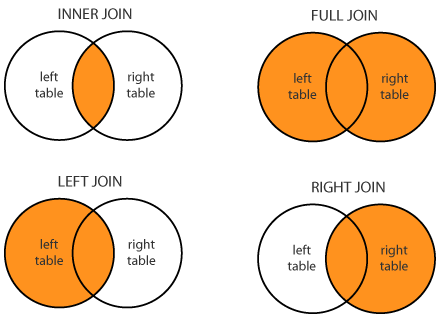

What we just did above is a left join on the Employees table. 

### Subqueries
We can also combine multiple queries, one working over the results of the others.

* Get all the employees whose salary is above average:

In [11]:
cursor.execute("""SELECT "name", salary FROM EMPLOYEES
                WHERE salary > 
                (
                    SELECT AVG(salary) FROM EMPLOYEES
                )
                ORDER BY salary ASC""")
rows = cursor.fetchall()
print(rows[0:20])

[('Kristy Flander', 49646.0), ('Michael Thompson', 49657.0), ('Earnest Martin', 49687.0), ('Pamela Wilson', 49774.0), ('Gary Hannan', 49774.0), ('Charles Hicks', 49780.0), ('Ruben Hayes', 49803.0), ('Lowell Kryder', 49818.0), ('Larry Wyatt', 49838.0), ('Vivian Watson', 49847.0), ('Ava Carter', 49865.0), ('Connie Dean', 49891.0), ('Lois Brown', 49914.0), ('Daniel Loftin', 49959.0), ('Holly Fitzpatrick', 49976.0), ('Richard Figueroa', 49991.0), ('Major Eunice', 49997.0), ('John Lawrence', 50014.0), ('Gerald Mcwhite', 50041.0), ('Beatrice Jones', 50047.0)]


* Get all the employees whose salary is above their city average:

In [12]:
cursor.execute("""SELECT e1."name", e1.salary, e1.city, cityavg.avgSalary 
                    FROM EMPLOYEES e1,
                    (
                        SELECT e2.city, AVG(e2.salary) AS avgSalary FROM EMPLOYEES e2 GROUP BY e2.city
                    ) cityavg
                    where e1.city=cityavg.city and 
                    e1.salary > cityavg.avgSalary""")

rows = cursor.fetchall()
print(rows[0:20])

[('Jennifer Peters', 96745.0, 'Guipúzcoa', 54109.0), ('Mary Watterson', 66712.0, 'Settimo Gioele', 50218.5), ('Nancy Lloyd', 74157.0, 'Tarragona', 55412.1875), ('David Contrell', 92809.0, 'Murcia', 49879.8), ('Rickey Jarquin', 56792.0, 'Quarto Annalisa', 46090.5), ('Kimberly Blasko', 97428.0, 'León', 60559.04347826087), ('Seymour Healy', 94322.0, 'Scottmouth', 51735.0), ('Wayne Lee', 63417.0, 'Soria', 47809.269230769234), ('Gladys Thomas', 64810.0, 'Granada', 58084.03571428572), ('Elizabeth Smith', 95971.0, 'Santa Cruz de Tenerife', 55367.24), ('Adelaida Logan', 74004.0, 'Melilla', 47929.0), ('Jaclyn Mcconnell', 54065.0, 'Palencia', 40414.96666666667), ('Roslyn White', 78561.0, 'Cádiz', 59426.27777777778), ('Tom Leone', 95118.0, 'Asturias', 56045.05882352941), ('Amanda Monroe', 99174.0, 'Lleida', 58844.375), ('Maria Neal', 70931.0, 'Almería', 49135.6129032258), ('Chadwick Frisby', 89869.0, 'Jaén', 55850.114285714284), ('Joyce Medina', 53082.0, 'Cuenca', 46101.25), ('Teresa Durden', 544

Notice how this time we used the subquery in the FROM section of the statement, and then we did a join with the employees table, adding for each employee what is the salary average of his city.

### Aggregation and joins: when things go wrong
Consider the following query: for all the projects with a budget >= 50k, get the average project budget by city.

Our first approach at solving this problem looked like this:

In [14]:
cursor.execute("""
    SELECT e.city, AVG(p.budget) FROM EMPLOYEES e, projects p
    WHERE p.budget  >= 50000 AND e.prj_id  = p.prj_id   
    GROUP BY e.city
    ORDER BY e.city desc 
""")
rows = cursor.fetchall()
print(rows[0:20])

[('Zecchini del friuli', Decimal('67668.000000000000')), ('Zaragoza', Decimal('73154.000000000000')), ('Zamoramouth', Decimal('75680.000000000000')), ('Zamora', Decimal('77742.769230769231')), ("Zaira nell'emilia", Decimal('61777.000000000000')), ('Zacharymouth', Decimal('78680.000000000000')), ("Zacco nell'emilia", Decimal('51824.000000000000')), ('Zaccagnini calabro', Decimal('52819.000000000000')), ('Yumouth', Decimal('84296.000000000000')), ('Youngchester', Decimal('67235.000000000000')), ('Yangtown', Decimal('68914.000000000000')), ('Wrightton', Decimal('56985.000000000000')), ('Woodsville', Decimal('84296.000000000000')), ('Wilsonstad', Decimal('79534.000000000000')), ('Williamstad', Decimal('71803.000000000000')), ('Williamsonberg', Decimal('96067.000000000000')), ('Williamsmouth', Decimal('67235.000000000000')), ('Williamsland', Decimal('75780.000000000000')), ('Williamside', Decimal('96547.000000000000')), ('Williamshaven', Decimal('60930.000000000000'))]


A result that looks correct. Let us focus on a single city.

In [15]:
[row for row in rows if row[0] == 'Salamanca']

[('Salamanca', Decimal('74359.192307692308'))]

Let's redo the query without the aggregation.

In [16]:
cursor.execute("""
    SELECT e.city, p.budget, p.prj_id  FROM projects p, employees e
    WHERE p.budget  >= 50000 AND p.prj_id = e.prj_id  AND e.city = 'Salamanca' 
    ORDER BY budget DESC
""")
cursor.fetchall()

[('Salamanca', 99180, 22),
 ('Salamanca', 93528, 86),
 ('Salamanca', 91384, 47),
 ('Salamanca', 90764, 96),
 ('Salamanca', 88759, 17),
 ('Salamanca', 88759, 17),
 ('Salamanca', 82489, 55),
 ('Salamanca', 82489, 55),
 ('Salamanca', 82489, 55),
 ('Salamanca', 81309, 75),
 ('Salamanca', 80104, 12),
 ('Salamanca', 74106, 40),
 ('Salamanca', 74015, 15),
 ('Salamanca', 71995, 87),
 ('Salamanca', 71803, 1),
 ('Salamanca', 71803, 1),
 ('Salamanca', 71803, 1),
 ('Salamanca', 68914, 48),
 ('Salamanca', 68914, 48),
 ('Salamanca', 60930, 68),
 ('Salamanca', 60930, 68),
 ('Salamanca', 58212, 38),
 ('Salamanca', 56739, 45),
 ('Salamanca', 56556, 82),
 ('Salamanca', 54403, 76),
 ('Salamanca', 50962, 61)]

Notice that project id 17, 55, 1 and others are repeated in this list. When we aggregate, those repeated rows are going to affect the final result. The repetition actually comes from the join operation:

In [17]:
cursor.execute("""
    SELECT *  FROM projects p WHERE p.prj_id = 1
""")
cursor.fetchall()

[(1, 'exotic-wallaby', 71803, datetime.date(2027, 11, 29))]

In [18]:
cursor.execute("""
SELECT *  FROM employees e WHERE e.prj_id = 1 and e.city ='Salamanca'
""")
cursor.fetchall()

[(3007, 'Glen Brown', 58995.0, 'Salamanca', 6, 1),
 (3507, 'Antonio Mcbride', 4222.0, 'Salamanca', 7, 1),
 (4009, 'Dolores Rumpf', 27823.0, 'Salamanca', 8, 1)]

The issue is that the join operation is repeating the information for every matched row. 

In order to fix this we need to remove duplicates before joining. 

In [19]:
cursor.execute("""
    SELECT fcities.city, avg(p.budget) FROM projects p, 
    (
        SELECT e.city, e.prj_id FROM employees e GROUP BY e.city, e.prj_id 
    ) fcities 
    WHERE p.budget >= 50000 AND p.prj_id = fcities.prj_id 
    GROUP BY fcities.city
    ORDER BY fcities.city
""")
rows = cursor.fetchall()
[row for row in rows if row[0] == 'Salamanca']

[('Salamanca', Decimal('74008.000000000000'))]

### Indexes
Sometimes, we will need to run queries that rely on columns which are not primary keys. In those cases, creating an index may help us speed the query. 

In the example below we select all the employees with a salary over 90k. We use Python's *timeit* library to execute it 10k times and take the average running time.

In [20]:
import timeit

def selection():
    return cursor.execute("""EXPLAIN ANALYZE SELECT "name" FROM EMPLOYEES WHERE salary > 90000""")

timeit.timeit(selection, number=10000)

3.688102272999913

Now let's see what happens if we define an index on the salary. For reference, btree is the default index option in Postgres and if you are interested there are plenty of details available out [there](https://en.wikipedia.org/wiki/B-tree). For now, we just need to know is a type of data structure that allows for fast searching.

In [21]:
cursor.execute("""CREATE INDEX employee_salary_idx ON EMPLOYEES USING btree (salary)""")
conn.commit()

If we repeat re-run the query we will see it is slightly faster.

In [22]:
timeit.timeit(selection, number=10000)

2.2133748270002798

4 secons may not seem like much, but remember that we are working with a very small dataset (there are only 4500 employees).

### When to use indexing
Just for the sake of experimentation, let's re-run the same query but this time selecting employees with salaries > than 40k. 

In [23]:
def selection():
    return cursor.execute("""EXPLAIN ANALYZE SELECT "name" FROM EMPLOYEES WHERE salary > 40000""")

timeit.timeit(selection, number=10000)

5.404414348000046

Notice how the execution time goes back up, just as before we created the index. What is going on? To find out open up a terminal if you are in Linux or a command line if you are in Windows and run:
```
psql
```

This will launch an interactive SQL session with the DB; default parameters are fine, you will just need to fill in the password.

In the SQL prompt, we will use the EXPLAIN ANALYZE instruction to look at the *query plan* for each of those queries: 

```
postgres=#  EXPLAIN ANALYZE SELECT * from employees WHERE salary > 40000;
                                                 QUERY PLAN
------------------------------------------------------------------------------------------------------------
 Seq Scan on employees  (cost=0.00..102.25 rows=2703 width=46) (actual time=0.011..0.590 rows=2706 loops=1)
   Filter: (salary > '40000'::double precision)
   Rows Removed by Filter: 1794
 Planning Time: 0.073 ms
 Execution Time: 0.717 ms
```

When we filter by salary > 40k, the filter removes 1794 rows (from 4500) and the DB does a sequential scan on the employees table.

```
postgres=#  EXPLAIN ANALYZE SELECT * from employees WHERE salary > 90000;
                                                           QUERY PLAN
---------------------------------------------------------------------------------------------------------------------------------
 Bitmap Heap Scan on employees  (cost=11.48..62.65 rows=413 width=46) (actual time=0.038..0.147 rows=414 loops=1)
   Recheck Cond: (salary > '90000'::double precision)
   Heap Blocks: exact=46
   ->  Bitmap Index Scan on employee_salary_idx  (cost=0.00..11.38 rows=413 width=0) (actual time=0.028..0.028 rows=414 loops=1)
         Index Cond: (salary > '90000'::double precision)
 Planning Time: 0.060 ms
 Execution Time: 0.179 ms
```

When we filter by salary > 90k, the DB uses the index and retrieves 414 rows.

What we are seeing here is the result of the DB planning strategy. In addition to processing SQL statements to retrieve and update data, a DB engine also has a planning component that analyzes each statement and decides what is the best way to execute it. In Postgres, the planner will only use an index if it returns a small number of rows.    


### Close the connection
Always remember to close the connection when you are done.

In [24]:
conn.close()

### Final  considerations
If you are not very familiar with a DB language like SQL, you may be tempted to use it as little as possible, i.e., get the data out of the DB and manipulate it with Python or any other language you are comfortable with. We would like to advice against that. DBs are optimized to do what they do: they can leverage multi-threading, use data indexes to make computations faster and cache your results. Plus, in data analysis you never know how you are going to get your data, so being familiar with SQL will pay off.

# Exercise

We will be working with the same dataset and questions we dealt with in the previous lab, so that you have some reference to work on (and check if your results match).

We will use the [Adult UCI dataset](https://archive.ics.uci.edu/ml/datasets/adult) with a few modifications; download the following files: [description](./files/adults/adults.names), [data - part1](./files/adults/adults1.csv) [data - part2](./files/adults/adults2.csv).

Follow the instructions below and answer the questions. 

1. Create the two tables in the DB with the right data dypes. In order to use enumerated types in the table definition you will first need to create the type. For example:

```
CREATE TYPE mood AS ENUM ('sad', 'ok', 'happy');
CREATE TABLE person (
    name text,
    current_mood mood
);
INSERT INTO person VALUES ('Moe', 'happy');
SELECT * FROM person WHERE current_mood = 'happy';
 name | current_mood 
------+--------------
 Moe  | happy
```

Notice that each row/sample does not have an id. Instead of using an INTEGER data type for the id, we recommend you look into SERIAL.

2. Load the datasets. We should use this version of the copy_from command where we specify the name of the columns and the value for NULL in the file of origin. Notice how we are not specifying the id column, since that will be autogenerated by the DB. Caveat: once you have loaded the data, double check that the id/SERIAL column starts at 1. 
```
cursor.copy_from(f, 'adults1', columns=('age', 'workclass', ...), sep=',', null='?')
```
3. How many people under 18 years old have never worked? Of the never having worked people (all ages) is there any race bias (how many by race)? Is there any sex bias? - Note: no need to elaborate, just present the data in tables. 
4. Look at the hours per week of people with a paying job, by sex. Look at how many's income is above and below 50k. Compare and analyse. - Note: no need to elaborate, produce a single table that shows the data for both sex and salary.
5. How many people with college education do manual labour?
6. What is the minimum, mean and maximum capital gain and capital loss for every marital status?